# Stimulus Response Analyses

This notebook explores stimulus response analysis to stimuli & events of interest. 

Investigated events:
- chest opening, including splitting by full and empty chests
- recall confidence prompt, which includes the image of the stimuli
- button response

#### Cells of interest 

THF-wv001-session_2:
- Neuron 51: maybe cares about full chests (non-specifically)

In [118]:
%config Completer.use_jedi = False

In [119]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from matplotlib.lines import Line2D

from convnwb.io import load_nwbfile

from spiketools.plts.trials import plot_rate_by_time
from spiketools.plts.annotate import add_vlines
from spiketools.plts.style import drop_spines
from spiketools.plts.trials import plot_rasters, create_raster_title
from spiketools.plts.utils import make_axes, save_figure, make_grid, get_grid_subplot
from spiketools.utils.epoch import epoch_spikes_by_event
from spiketools.utils.base import select_from_list
from spiketools.measures.trials import compute_trial_frs
from spiketools.stats.trials import compare_pre_post_activity

In [120]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [121]:
# Define the base data folder
data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'
#data_folder = '/data12/jacobs_lab/WVTH/nwb'

In [122]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv004',
    'session' : 0
}

In [123]:
# Set a unit of interest to select
uind = 60

In [124]:
# Set the time range to analyze, and pre & post trial windows (in seconds)
trial_range = [-1, 1]
pre_window = [-1, 0]
post_window = [0, 1]

## Load Data

In [125]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [126]:
# Get the chest trial indices & stimuli information
chest_trials = nwbfile.trials.chest_trials[:]

In [127]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 138
Number to keep:  90


In [128]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Chest Opening

In [129]:
# Get times of chest opening
openings = nwbfile.trials.chest_opening_time[:]

In [130]:
# Check the number of chests
n_chests = len(openings)
print('Number of chests: {}'.format(n_chests))

Number of chests: 128


In [131]:
# Gather neural data around trials of interest
all_trials_chest = epoch_spikes_by_event(spikes, openings, trial_range)

In [132]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_trials_chest, pre_window, post_window)

## Chest Opening - Split by Stimulus Content

In [133]:
# Create masks to sub-select full & empty chests
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [134]:
# Calculate how many full/empty chests there are
n_empty = sum(empty_mask)
n_full = sum(full_mask)

In [135]:
# Check how many full/empty chests there are
print('Number of empty chests: \t{}'.format(n_empty))
print('Number of full chests: \t\t{}'.format(n_full))

Number of empty chests: 	48
Number of full chests: 		80


In [136]:
# Sub-select full & empty chest trials
empty_trials = select_from_list(all_trials_chest, empty_mask)
full_trials = select_from_list(all_trials_chest, full_mask)

In [137]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre_e, avg_post_e, t_val_e, p_val_e = compare_pre_post_activity(empty_trials, pre_window, post_window)
avg_pre_f, avg_post_f, t_val_f, p_val_f = compare_pre_post_activity(full_trials, pre_window, post_window)

In [138]:
tbins = np.arange(-1, 1 + 0.1, 0.1)

In [139]:
full_frs_trial = compute_trial_frs(full_trials, 0.1, time_range=[-1,1])
empty_frs_trial = compute_trial_frs(empty_trials, 0.1, time_range=[-1,1])

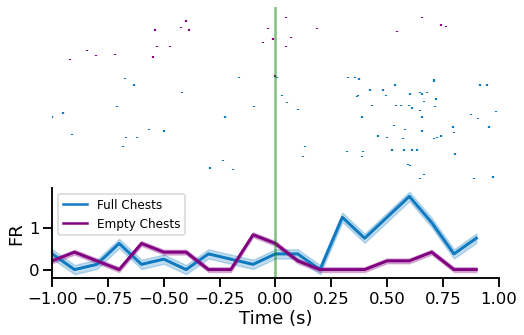

In [140]:
# Plot a comparison of full and empty trials
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters([full_trials, empty_trials], xlim=trial_range, vline=0, ax=get_grid_subplot(grid, slice(0, 2), 0), 
             colors=['#D95319', 'purple'])
plot_rate_by_time(tbins[:-1], [full_frs_trial.mean(0), empty_frs_trial.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors=['#D95319', 'purple'])
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')

legend_elements = [Line2D([0], [0], color='#D95319', lw=2.5, label='Full Chests'),
                  Line2D([0], [0], color='purple', lw=2.5, label='Empty Chests')]
plt.legend(handles=legend_elements, loc='best', ncol=1, fontsize=12)
drop_spines(get_grid_subplot(grid, 2, 0), ['top', 'right'])

# save_figure('fig2_chestface'+'.svg','/Users/clairehan/Desktop/paper_fig', close=False, bbox_inches='tight')

## Recall Events

In [23]:
# Get the response times of interest
prompts = nwbfile.trials.confidence_prompt_time[:]
responses = nwbfile.trials.response_time[:]

In [24]:
# Check the number of recall events
assert len(prompts) == len(responses)
n_recalls = len(prompts)
print('Number of recall events: {}'.format(n_recalls))

Number of recall events: 60


### Response Prompt

In [25]:
# Gather neural data around trials of interest
all_trials_prompt = epoch_spikes_by_event(spikes, prompts, trial_range)

In [26]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_trials_prompt, pre_window, post_window)

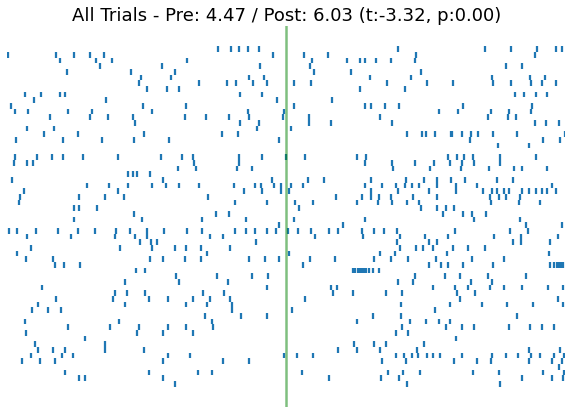

In [27]:
# Plot raster across all response prompts
plot_rasters(all_trials_prompt, xlim=trial_range, vline=0, figsize=(10, 7), 
             title=create_raster_title('All Trials', avg_pre, avg_post, t_val, p_val))

### Response Button Press

In [28]:
# Gather neural data around trials of interest
all_trials_response = epoch_spikes_by_event(spikes, responses, trial_range)

In [29]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_trials_response, pre_window, post_window)

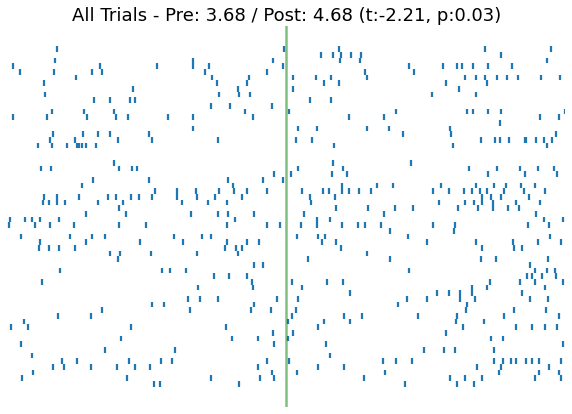

In [30]:
# Plot raster across all response button presses
plot_rasters(all_trials_response, xlim=trial_range, vline=0, figsize=(10, 7), 
             title=create_raster_title('All Trials', avg_pre, avg_post, t_val, p_val))

### Check All Cells

In [31]:
# Set which set of events to run
event_label = 'openings' # 'openings', 'prompts', 'responses'

In [32]:
# # Run across all cells
# events = {'openings' : openings, 'prompts' : prompts, 'responses' : responses}[event_label]
# for uind in keep_inds:

#     spikes = nwbfile.units.get_unit_spike_times(uind)        
#     all_trials = epoch_spikes_by_event(spikes, events, trial_range)
    
#     avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_trials, pre_window, post_window)
    
#     # Plot all trials together
#     plot_rasters(all_trials, xlim=trial_range, vline=0, figsize=(10, 7),
#                  title=create_raster_title(f'Neuron #{uind}', avg_pre, avg_post, t_val, p_val))

#     # Plot separate rasters for full and empty trials
#     if event_label == 'openings':
#         axes = make_axes(2, 2, wspace=0.1, figsize=(16, 5),
#                          title='Neuron #{}'.format(uind), title_y=1.05)
        
#         empty_trials = select_from_list(all_trials, empty_mask)
#         avg_pre_e, avg_post_e, t_val_e, p_val_e = compare_pre_post_activity(empty_trials, pre_window, post_window)
#         plot_rasters(empty_trials, xlim=trial_range, vline=0, ax=axes[0],
#                      title=create_raster_title(f'Neuron #{uind}', avg_pre_e, avg_post_e, t_val_e, p_val_e))
        
#         full_trials = select_from_list(all_trials, full_mask)
#         avg_pre_f, avg_post_f, t_val_f, p_val_f = compare_pre_post_activity(full_trials, pre_window, post_window)
#         plot_rasters(full_trials, xlim=trial_range, vline=0, ax=axes[1],
#                      title=create_raster_title(f'Neuron #{uind}', avg_pre_f, avg_post_f, t_val_f, p_val_f))